# Base/Denoising Autoencoder & Dimension Reduction

## Introduction

![](https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/autoencoder/base-denoising-autoencoder-dimension-reduction/base_noise.gif)



Autoencoder is a neural network that simply copies input to output. In some ways, it looks like a simple neural network, but it makes a difficult neural network by constraining the network in various ways. For example, the number of neurons in the hidden layer is smaller than that of the input layer to compress the data (reduce the dimension), or add noise to the input data and then restore the original input. There are various autoencoders, such as learning These constraints prevent the autoencoder from simply copying the input directly to the output, and control it to learn how to represent the data efficiently.

In this notebook, we will cover two autoencoders:
* **Base AutoEncoder**
* **Denoising Autoencoder**


In [ ]:
# Install the necessary dependencies

import os
import sys  
!{sys.executable} -m pip install --quiet pandas matplotlib jupyterlab_myst ipython tensorflow umap plotly

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow  as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Loading and Scaling Datasets
Train a basic autoencoder using the Fashon MNIST dataset. Each image in this dataset is 28x28 pixels.
Inputs are scaled for training.

In [20]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Load model

In [21]:
import os
import requests
import zipfile

In [22]:
model_url = "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/autoencoder/base-denoising-autoencoder-dimension-reduction/base-denoising-autoencoder-dimension-reduction_model.zip"

notebook_path = os.getcwd()

tmp_folder_path = os.path.join(notebook_path, "tmp")

if not os.path.exists(tmp_folder_path):
    os.makedirs(tmp_folder_path)

file_path = os.path.join(tmp_folder_path,"base-denoising-autoencoder-dimension-reduction")

if not os.path.exists(file_path):
    os.makedirs(file_path)

zip_store_path = os.path.join(file_path, "zip-store")

if not os.path.exists(zip_store_path):
    os.makedirs(zip_store_path)

model_response = requests.get(model_url)

model_name = os.path.basename(model_url)

model_save_path = os.path.join(zip_store_path, model_name)

with open(model_save_path, "wb") as file:
    file.write(model_response.content)

In [23]:
zip_file_path = f"./tmp/base-denoising-autoencoder-dimension-reduction/zip-store/{model_name}"
extract_path = "./tmp/base-denoising-autoencoder-dimension-reduction/base-denoising-autoencoder-dimension-reduction_model"

zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall(extract_path)
zip_ref.close()


### Checking dataset by 2D plot

Autoencoding can be thought of as a kind of dimensionality reduction process. Therefore, after compressing the fashion MNIST dataset through UMAP in two dimensions, let's check how it is mapped for each label.

In [24]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)

In [25]:
labels = { 0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
          5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8 : 'Bag', 9 : 'Ankle boot'}

In [26]:
y_train = pd.DataFrame(y_train,columns=['class'])
y_train["class"].replace(labels, inplace=True)

<AxesSubplot: >

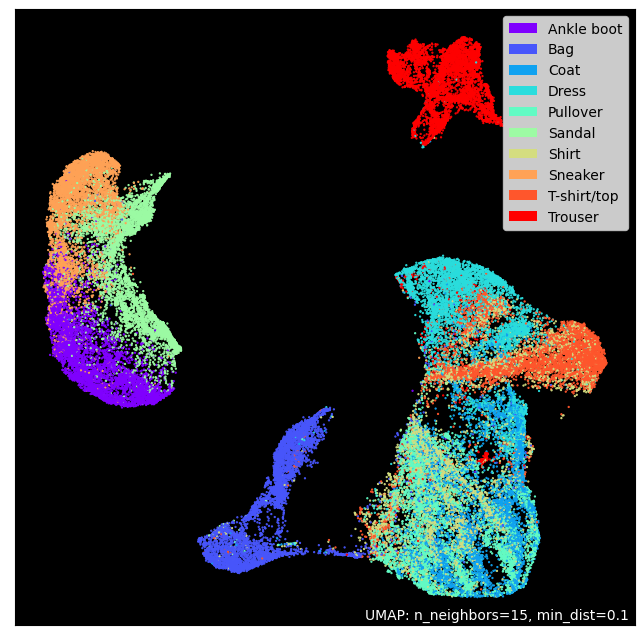

In [27]:
import umap.plot
mapper_org = umap.UMAP().fit(x_train_flat)
umap.plot.points(mapper_org, labels=y_train["class"], theme='fire')

Looking at the distribution of data projected in two dimensions, it seems that compression with an autoencoder would be sufficient.

<AxesSubplot: >

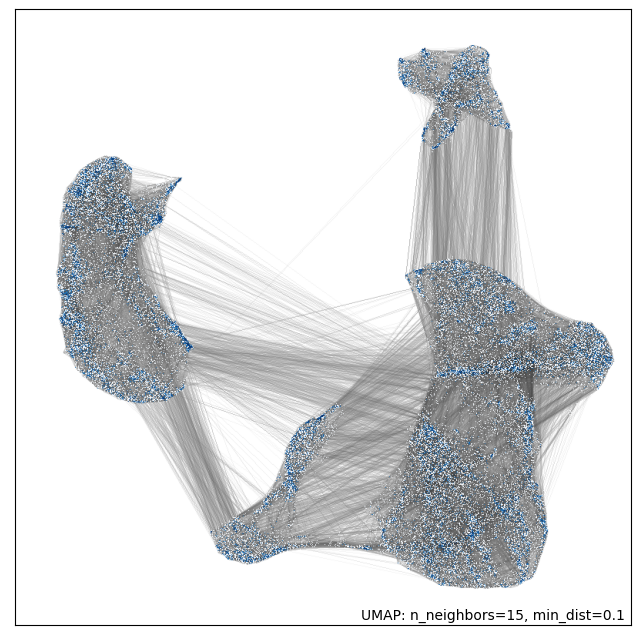

In [28]:
umap.plot.connectivity(mapper_org, show_points=True)

> UMAP works by constructing an intermediate topological representation of the approximate manifold the data may have been sampled from. In practice this structure can be simplified down to a weighted graph. Sometimes it can be beneficial to see how that graph (representing connectivity in the manifold) looks with respect to the resulting embedding. It can be used to better understand the embedding, and for diagnostic purposes. 

Ref: https://umap-learn.readthedocs.io/en

### Checking dataset by 3D plot

In [29]:
import plotly.express as px
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(x_train_flat)
umap_df = pd.DataFrame(x_umap)
new_df = pd.concat([umap_df,y_train["class"]],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='class', labels={'color': 'class'}
)
fig.update_traces(marker_size=1)
fig.show()

d:\conda\envs\py39\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


We have approximated the distribution of the training dataset we want to train with 2D and 3D compressed datasets. Autoencoder is another compression method using neural networks.

**Now, let's do modeling and training for Autoencoder.**

## Base Autoencoder



### Modeling
An autoencoder always consists of two parts: an encoder and a decoder.
* Encoder (Recognition network): it transforms an input into an internal representation.
* Decoder (generative network): it transforms an internal representation into an output.

The autoencoder has the same structure as a general MLP (Multi-Layer Perceptron) except that the number of neurons in the input and output layers is same. Since the autoencoder reconstructs the input, the output is also called reconstruction, and the loss function is calculated with the difference between the input and the reconstruction (output).

The neurons (nodes, units) of the hidden layer are smaller than the input layer, so the input is expressed in a low-dimensional manner. Such an autoencoder is called an undercomplete autoencoder. Because an undercomplete autoencoder cannot copy the input to the output as it is by a hidden layer with low dimensions, the output must learn to output the same as the input. Through this learning, the undercomplete autoencoder learns the most important features from the input data.

In [30]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),                  # (1,784)
      layers.Dense(latent_dim, activation='relu'),  
    ])                                   # (1,784)(784,64) => (1,64)
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))           # (1,64)(64,784) => (1,784) => (1,28,28)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim)

In [37]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

### Training

Train the model using x_train as input and target. The encoder learns to compress the dataset into a latent space in 784 dimensions, and the decoder learns to reconstruct the original image.

In [ ]:
# autoencoder.fit(x_train, x_train,
#                  epochs=10,
#                  shuffle=True,
#                  validation_data=(x_test, x_test))

# autoencoder.save("base-denoising-autoencoder-dimension-reduction_model", save_format='tf')

In [62]:
autoencoder = tf.keras.models.load_model("./tmp/base-denoising-autoencoder-dimension-reduction_model")

In [41]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

### Plotting the latent space after Dimension Reduction

In [42]:
y_test = pd.DataFrame(y_test,columns=['class'])
y_test["class"].replace(labels, inplace=True)

<AxesSubplot: >

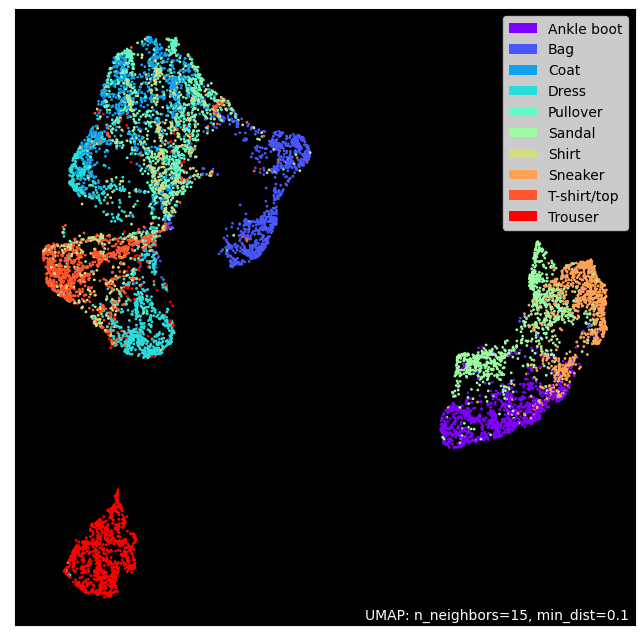

In [43]:
mapper = umap.UMAP().fit(encoded_imgs)
umap.plot.points(mapper, labels=y_test["class"],theme='fire')

The $28*28$ dimension input is compressed into the $7*7$ latent space by the encoder. The latent space is compressed into 2D using Dimension Reduction. Although it is an approximate expression, it can be seen that each class is well clustered in the compressed latent space.

### Checking results

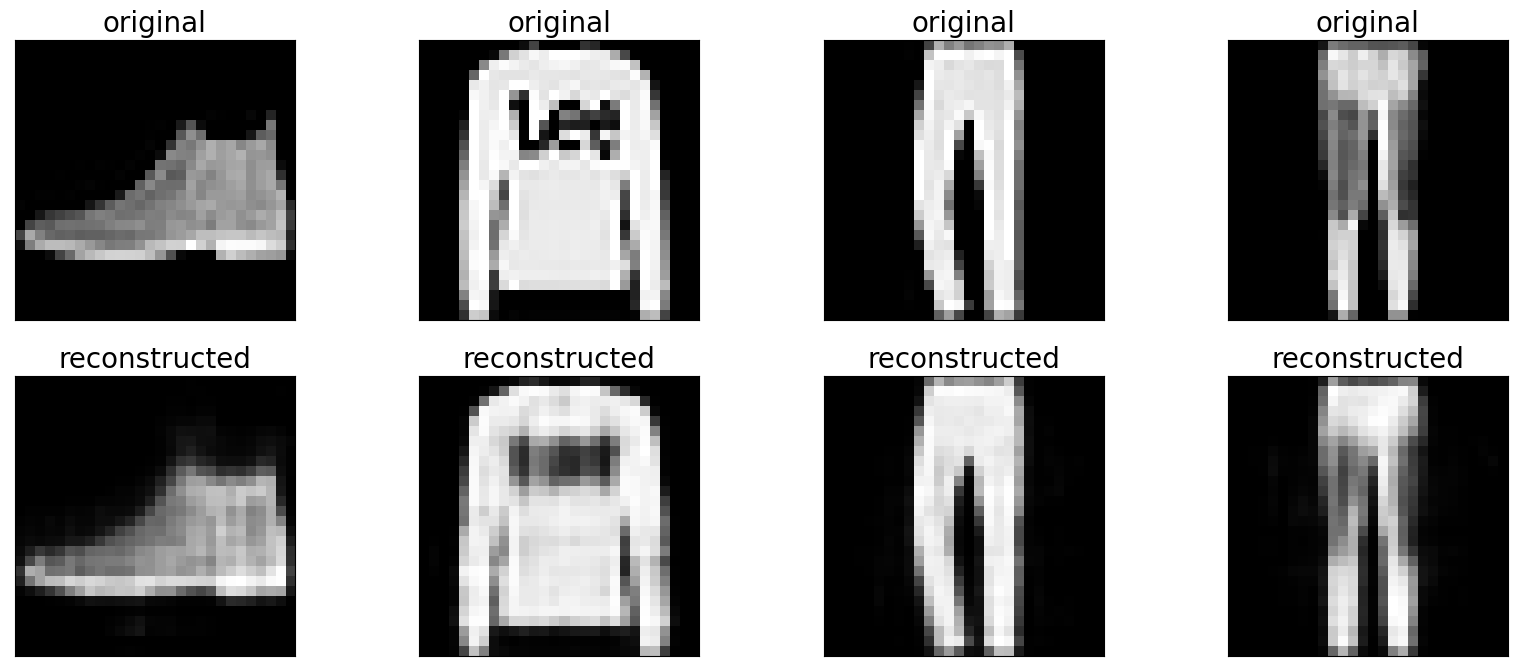

In [44]:
n = 4
plt.figure(figsize=(20, 8))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original",fontsize=20)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed",fontsize=20)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Looking at the result, the reconstructed image looks a little blurry. However, it can be confirmed that the overall characteristics are expressed.

## Denoising Autoencoder

Another way to constrain the autoencoder to learn meaningful features is to add noise to the input and train it to reconstruct the original noise-free input. Noise can be generated by adding Gaussian noise to the input as shown in the figure below, or by randomly turning off the input unit (node) like a dropout.

In [45]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [46]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


### Adding random noise to the image.

In [47]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

### Plotting a noisy image.

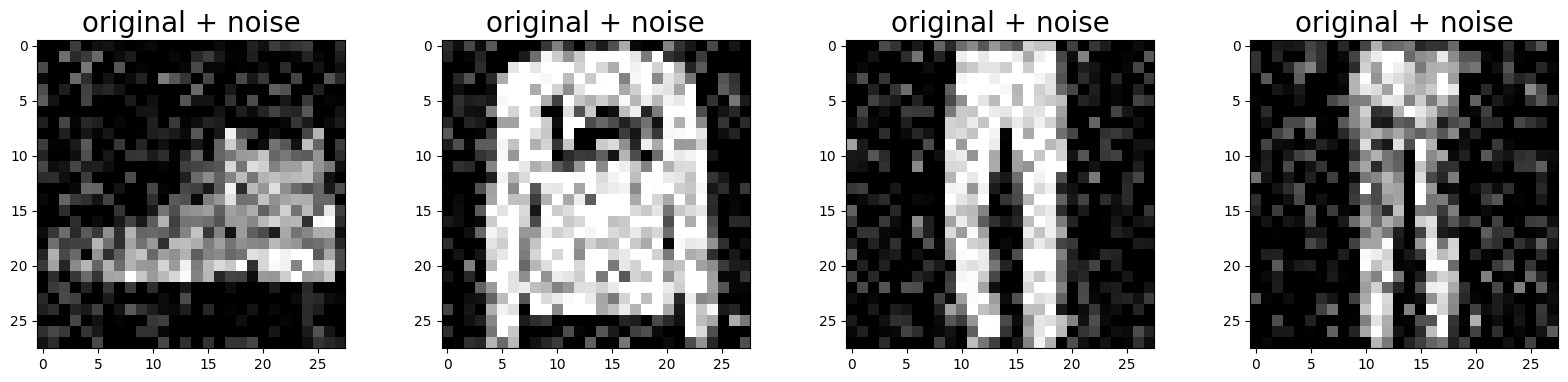

In [48]:
n = 4
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise",fontsize=20)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Checking Noisy Dataset using Demension Reduction

#### 1) Noisy Dataset

In [49]:
x_train_noisy_flat = x_train.reshape(x_train_noisy.shape[0], -1)

In [50]:
y_train = pd.DataFrame(y_train,columns=['class'])
y_train["class"].replace(labels, inplace=True)

<AxesSubplot: >

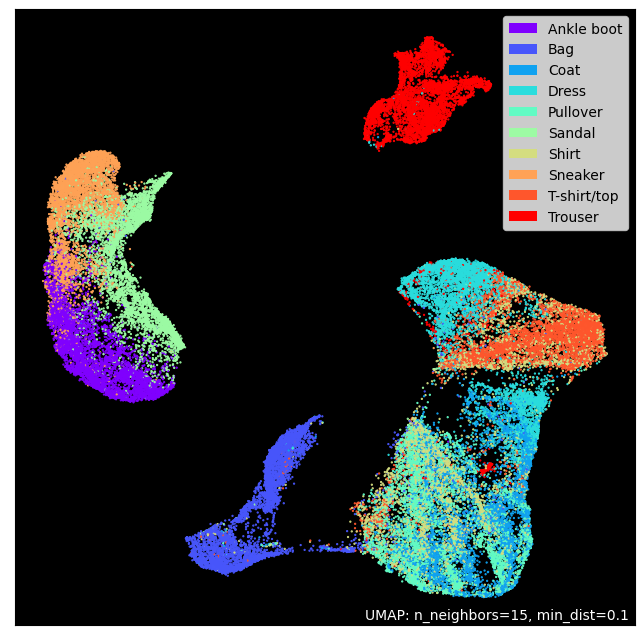

In [51]:
mapper_noisy = umap.UMAP().fit(x_train_noisy_flat)
umap.plot.points(mapper_noisy, labels=y_train['class'], theme='fire')

#### 2) Orignal Dataset

In [52]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)

<AxesSubplot: >

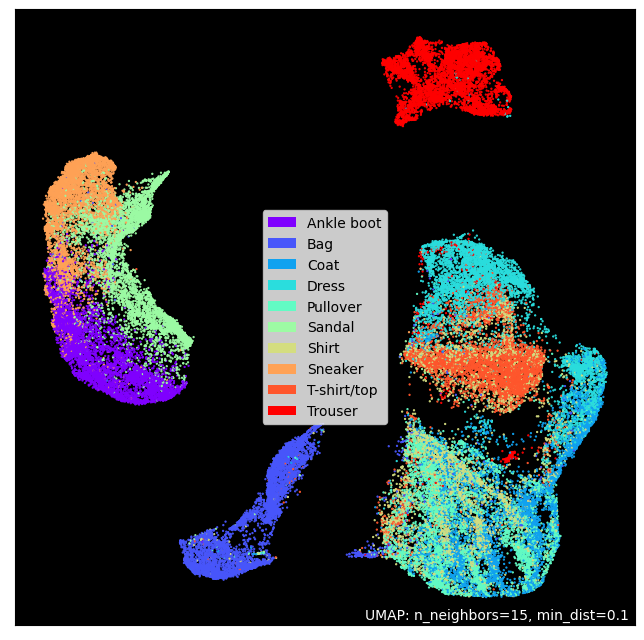

In [53]:
mapper_org = umap.UMAP().fit(x_train_flat)
umap.plot.points(mapper_org, labels=y_train['class'], theme='fire')

When looking at the two-dimensionally scaled-down pictures, the difference is not very visible. However, if you look at the picture on the upper right, you can see that the distribution of the blue dots is slightly different. Also, the distribution of purple has changed.
In any case, the visually large noise does not show much difference after dimensionality reduction.

The image observed with our eyes may appear to be noisy, but from the model's point of view the noise may not be so great!

Now let's do some modeling and training with this noisy dateset.

### Modeling

In [54]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [55]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

### Training

In [56]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x0000020AD04AD280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x0000020AD04AD280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x0000020AD04AD280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1874/1875 [============================>.] - ETA: 0s - loss: 0.0196WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000020AD0975280> and will run it as-is.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x0000020AD0975280>. Note that functions defined in certain environments, like the interactive Python shell, do no

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x0000020AD0975280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x0000020AD0975280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1875/1875 [==============================] - 91s 46ms/step - loss: 0.0196 - val_loss: 0.0097
Epoch 2/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 3/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 4/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 5/10
1875/1875 [=============

Let's take a look at the encoder summary. The image is downsampled from 28x28 to 7x7.

In [57]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


The decoder upsamples the image back from 7x7 to 28x28.

In [58]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


### Checking results

Plots both the noisy and denoised images generated by the autoencoder.

In [59]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

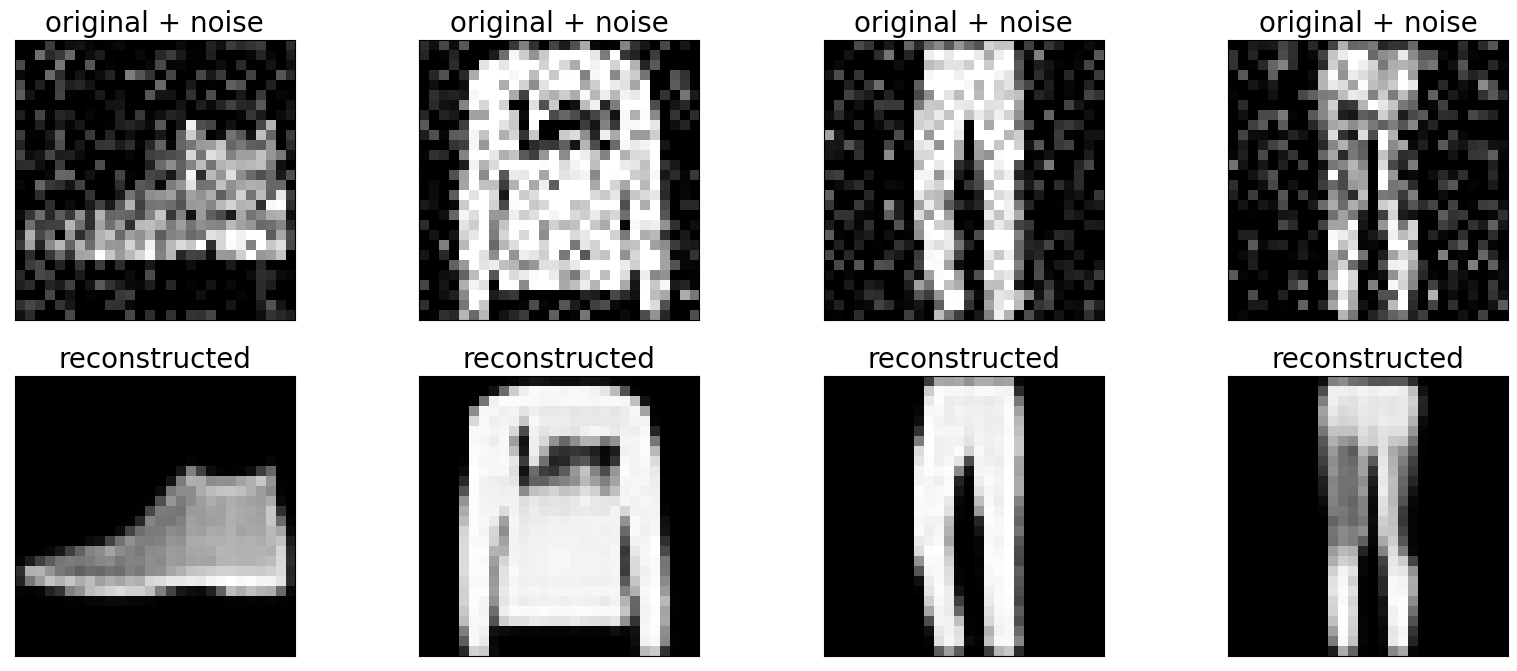

In [60]:
n = 4
plt.figure(figsize=(20, 8))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise",fontsize=20)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed",fontsize=20)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Acknowledgments

Thanks to TOH SEOK KIM for creating the Kaggle open-source project [Base/Denoising Autoencoder + Dimension Reduction](https://www.kaggle.com/code/ohseokkim/base-denoising-autoencoder-dimension-reduction). It inspires the majority of the content in this chapter.